<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/Darts/Darts_Quick_Start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

Check GPU

In [1]:
!nvidia-smi

Sun Oct  2 05:33:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install Darts

In [2]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 424 kB 14.6 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 9.8 MB 84.1 MB/s 
     |████████████████████████████████| 1.8 MB 64.2 MB/s 
     |████████████████████████████████| 76.8 MB 102.3 MB/s 
     |████████████████████████████████| 11.2 MB 69.8 MB/s 
     |████████████████████████████████| 44 kB 2.9 MB/s 
     |████████████████████████████████| 708 kB 90.6 MB/s 
     |████████████████████████████████| 1.6 MB 73.4 MB/s 
     |████████████████████████████████| 960 kB 83.3 MB/s 
     |████████████████████████████████| 419 kB 92.1 MB/s 
     |████████████████████████████████| 5.9 MB 88.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: tensorb

Library

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

# Load Dataset

In [2]:
series = AirPassengersDataset().load()

In [4]:
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

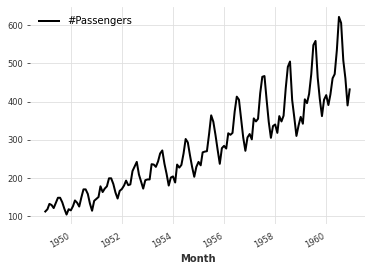

In [5]:
series.plot()

# Split Dataset

In [11]:
train, val = series.split_before(pd.Timestamp("19580101"))

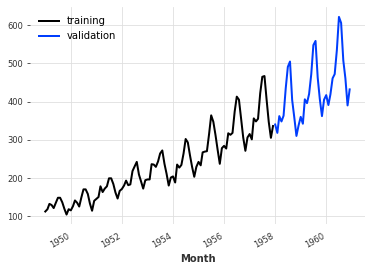

In [12]:
train.plot(label="training")
val.plot(label="validation")

splitting

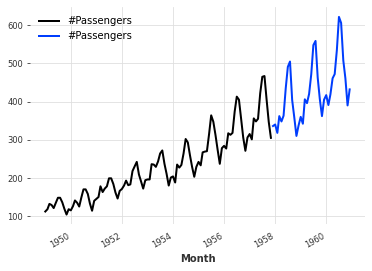

In [17]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

slicing

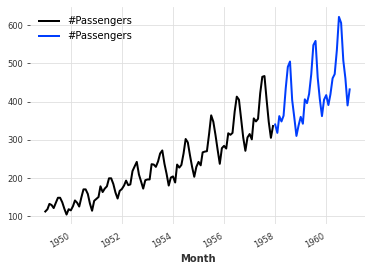

In [18]:
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()

arithmetic operation

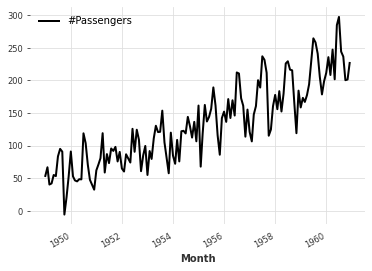

In [19]:
series_noise = TimeSeries.from_times_and_values(series.time_index,
                                                np.random.randn(len(series)))

(series / 2 + 20 * series_noise - 10).plot()

stacking

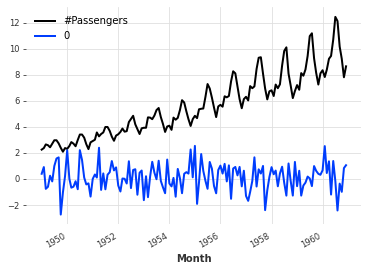

In [20]:
(series / 50).stack(series_noise).plot()

mapping

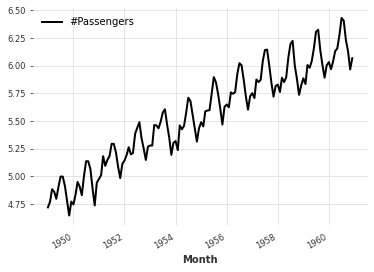

In [21]:
series.map(np.log).plot()

mapping on both timestamps and values

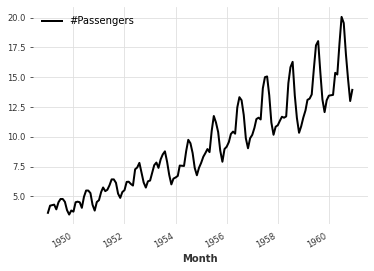

In [22]:
series.map(lambda ts, x: x / ts.days_in_month).plot()

Adding some datetime attribute as an extra dimension (yielding a multivariate series)

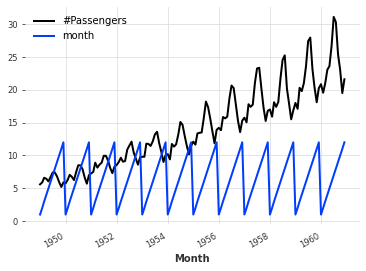

In [24]:
(series / 20).add_datetime_attribute("month").plot()

Adding some binary holidays component

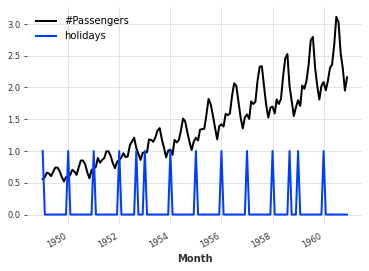

In [25]:
(series / 200).add_holidays("US").plot()

differencing

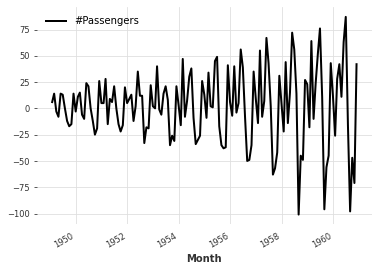

In [26]:
series.diff().plot()

# Filling missing values

In [27]:
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)

values[10:30] = np.nan
values[60:95] = np.nan

series_ = TimeSeries.from_values(values)

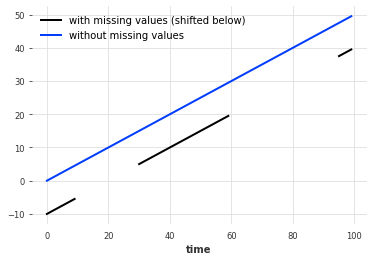

In [28]:
(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

# Inspect Seasonality

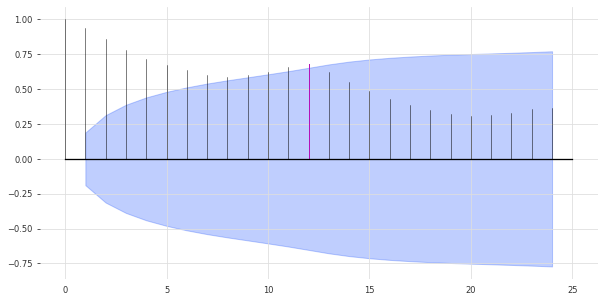

In [31]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [32]:
for m in range(2, 25):

    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)

    if is_seasonal:
      
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


# Training Models

Naive Seaonal model

In [29]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)

naive_forecast = naive_model.predict(36)

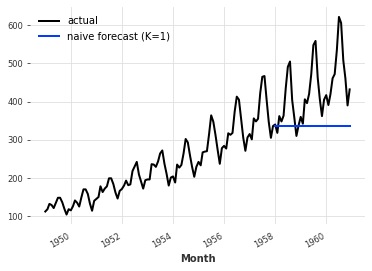

In [30]:
series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

A less naive model

In [33]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)

seasonal_forecast = seasonal_model.predict(36)

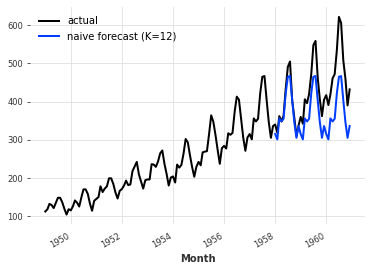

In [34]:
series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

Naive Drift Models

In [15]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)

drift_forecast = drift_model.predict(36)

In [35]:
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

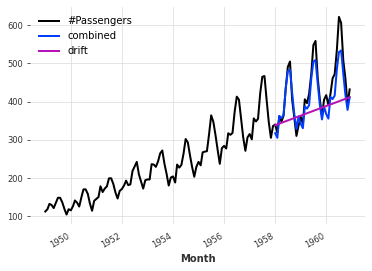

In [36]:
series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

# Computing error metrics

In [37]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


# Quickly try out several models (ExponentialSmoothing, TBATS, AutoARIMA, Theta)

In [38]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

In [39]:
list_model = [
    ExponentialSmoothing(),
    TBATS(),
    AutoARIMA(),
    Theta()
]

for model in list_model:

  eval_model(model)

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%
model (T)BATS obtains MAPE: 5.87%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


# Searching for hyper-parameters with the Theta method¶

In [40]:
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

In [41]:
for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [42]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


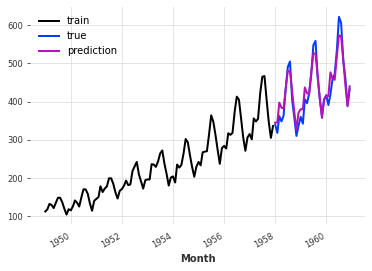

In [43]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

# Backtesting: simulate historical forecasting

100%|██████████| 57/57 [00:01<00:00, 38.27it/s]


MAPE = 7.70%


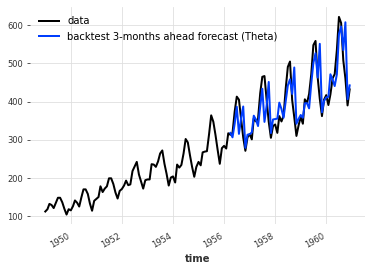

In [44]:
historical_fcast_theta = best_theta_model.historical_forecasts(series,
                                                               start=0.6,
                                                               forecast_horizon=3,
                                                               verbose=True)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")

print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

100%|██████████| 57/57 [00:01<00:00, 37.05it/s]


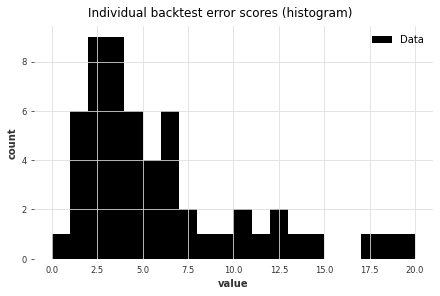

In [45]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [46]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

100%|██████████| 57/57 [00:01<00:00, 42.35it/s]


Average error (MAPE) over all historical forecasts: 6.36


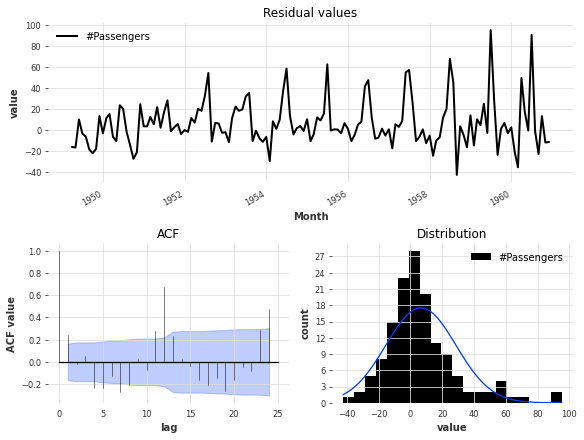

In [47]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

100%|██████████| 57/57 [00:05<00:00, 10.04it/s]


MAPE = 4.45%


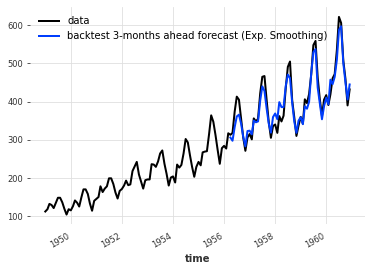

In [48]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(series,
                                                    start=0.6,
                                                    forecast_horizon=3,
                                                    verbose=True)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")

print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

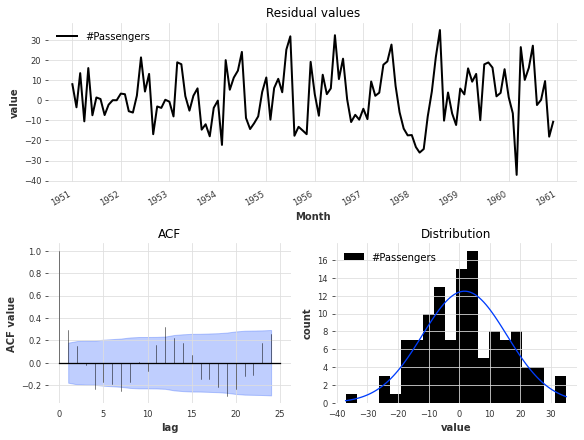

In [49]:
plot_residuals_analysis(model_es.residuals(series))

# A toy example with two series

In [50]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

In [51]:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

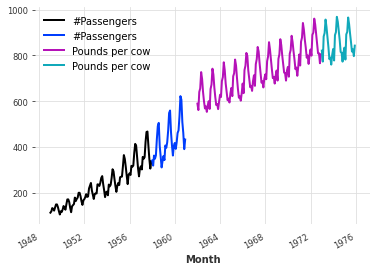

In [52]:
train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

In [53]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

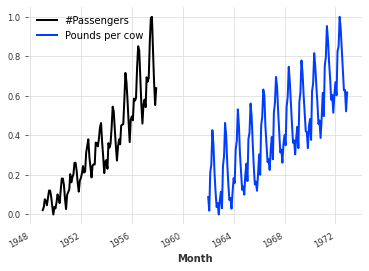

In [54]:
train_air_scaled.plot()
train_milk_scaled.plot()

# Using deep learning: example with N-BEATS

In [55]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24,
                    output_chunk_length=12,
                    random_state=42)

model.fit([train_air_scaled, train_milk_scaled],
          epochs=50,
          verbose=True);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [56]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

In [57]:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

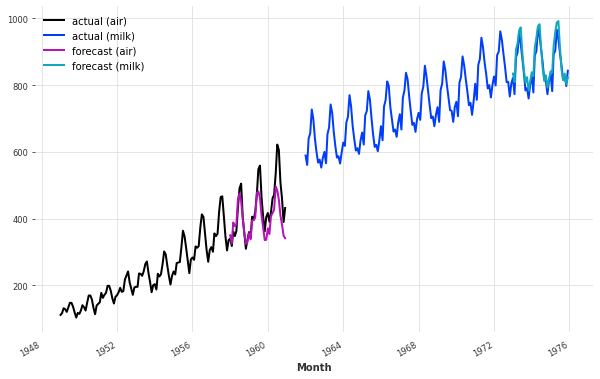

In [58]:
plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

# Covariates: using external data

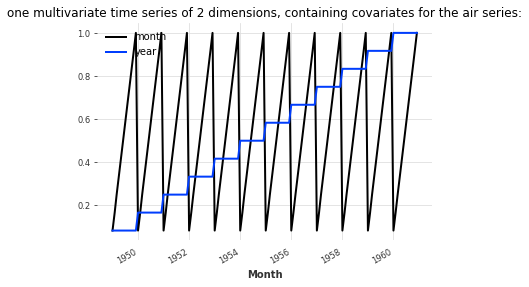

In [59]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [60]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [61]:
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

In [62]:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

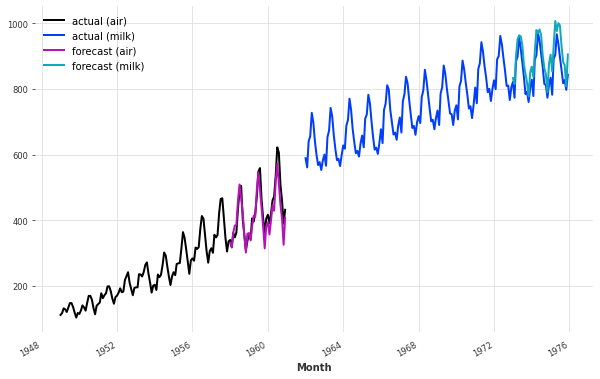

In [63]:
plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

# Encoders: using covariates for free

In [64]:
encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "custom": {"past": [lambda idx: (idx.year - 1950) / 50]},
    "transformer": Scaler(),
}

In [65]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

In [66]:
model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

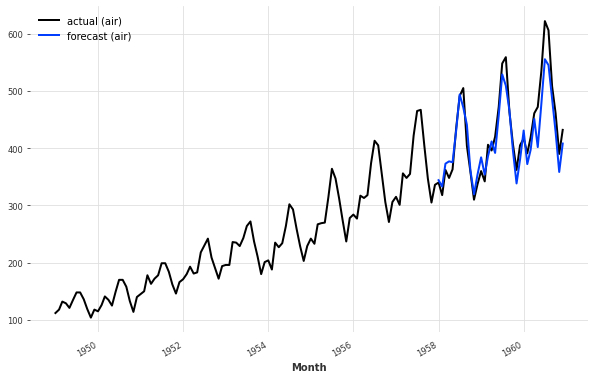

In [67]:
pred_air = model.predict(series=train_air_scaled, n=36)

pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

# Regression forecasting models

In [68]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72,
                        lags_future_covariates=[-6, 0],
                        model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled],
     future_covariates=[air_covs, milk_covs])

In [69]:
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36)

In [70]:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

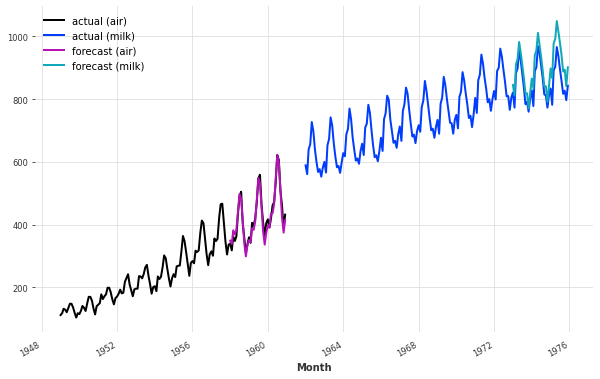

In [71]:
plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [72]:
mape([series_air, series_milk], [pred_air, pred_milk])

[3.4172054919448067, 5.283041687692616]

In [73]:
mape([series_air, series_milk], [pred_air, pred_milk], inter_reduction=np.mean)

4.350123589818711

100%|██████████| 57/57 [00:03<00:00, 15.38it/s]


MAPE = 3.66


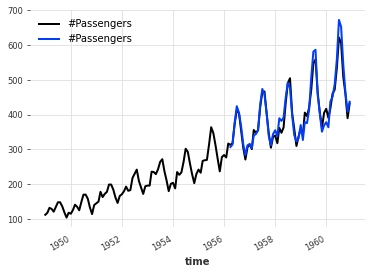

In [74]:
bayes_ridge_model = RegressionModel(lags=72,
                                    lags_future_covariates=[0],
                                    model=BayesianRidge())

backtest = bayes_ridge_model.historical_forecasts(series_air,
                                                  future_covariates=air_covs,
                                                  start=0.6,
                                                  forecast_horizon=3,
                                                  verbose=True)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

# Probabilistic forecasts

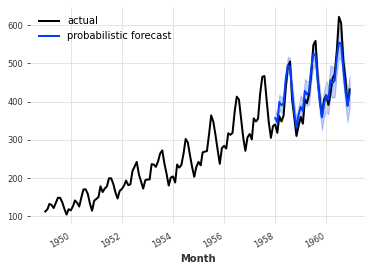

In [75]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

# With neural networks

In [76]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_air_scaled, epochs=400, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
--------------------------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Predicting: 3it [00:00, ?it/s]

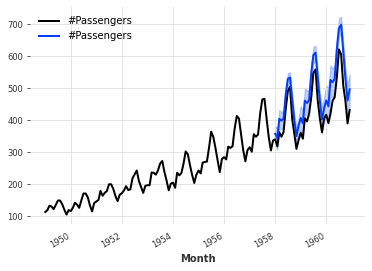

In [77]:
pred = model.predict(n=36, num_samples=500)

pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

In [78]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.1),
)

model.fit(train_air_scaled, epochs=400, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1767: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
--------------------------------------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Predicting: 3it [00:00, ?it/s]

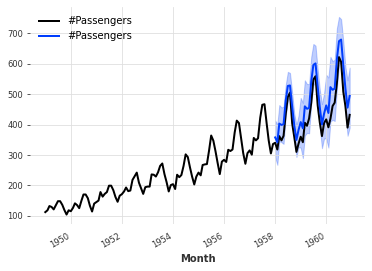

In [79]:
pred = model.predict(n=36, num_samples=500)

pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

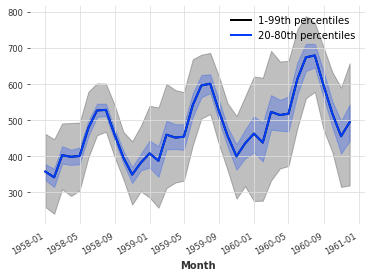

In [80]:
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

# Naive Ensembling

In [81]:
from darts.models import NaiveEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = NaiveEnsembleModel(models=models)

backtest = ensemble_model.historical_forecasts(series_air,
                                               start=0.6,
                                               forecast_horizon=3,
                                               verbose=True)

100%|██████████| 57/57 [00:00<00:00, 58.80it/s]


In [82]:
print("MAPE = %.2f" % (mape(backtest, series_air)))

MAPE = 11.88


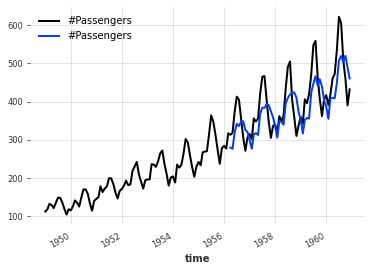

In [83]:
series_air.plot()
backtest.plot()

# Learned Ensembling

In [84]:
from darts.models import RegressionEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(forecasting_models=models,
                                         regression_train_n_points=12)

backtest = ensemble_model.historical_forecasts(series_air,
                                               start=0.6,
                                               forecast_horizon=3,
                                               verbose=True)

100%|██████████| 57/57 [00:01<00:00, 28.61it/s]


In [85]:
print("MAPE = %.2f" % (mape(backtest, series_air)))

MAPE = 4.85


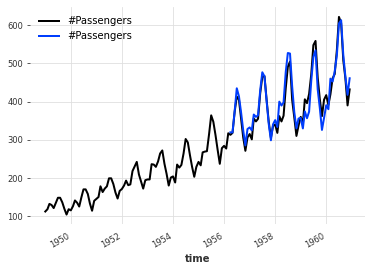

In [86]:
series_air.plot()
backtest.plot()

# Fitting a Kalman Filter

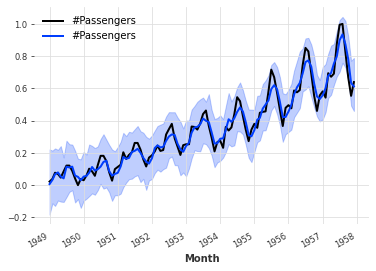

In [87]:
from darts.models import KalmanFilter

kf = KalmanFilter(dim_x=3)
kf.fit(train_air_scaled)
filtered_series = kf.filter(train_air_scaled, num_samples=100)

train_air_scaled.plot()
filtered_series.plot()

# Inferring missing values with Gaussian Processes

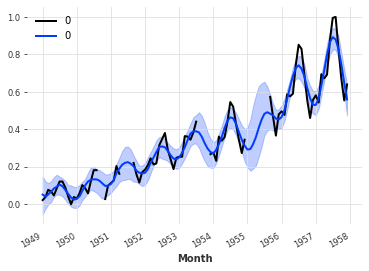

In [88]:
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF

values = train_air_scaled.values()
values[20:22] = np.nan
values[28:32] = np.nan
values[55:59] = np.nan
values[72:80] = np.nan
series_holes = TimeSeries.from_times_and_values(train_air_scaled.time_index, values)
series_holes.plot()

kernel = RBF()

gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
filtered_series = gpf.filter(series_holes, num_samples=100)

filtered_series.plot()